In [ ]:
import numpyro
from tqdm import tqdm
from jax import random
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numba import jit, njit,prange
import numba as nb
from numba.numpy_support import from_dtype
from numba import njit, objmode
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import jax.numpy as jnp
import jax as jax
from jax import jit
jax.local_device_count()
import arviz as az
import os



In [ ]:
import pandas as pd
lower=16
upper=81
sub=61-lower
raw_d=pd.read_csv("/home/DIDE/sjbhatt/UK_deaths_covid_epidemiafit.csv")
raw_d = raw_d.iloc[16:upper,:]
deaths_real = np.array(raw_d['deaths'])
x=np.linspace(0,raw_d.shape[0]-1,raw_d.shape[0])
N = x.shape[0]
print(raw_d.shape)
print(N)
dates =  np.arange('2020-02-01', '2020-04-06', dtype='datetime64[D]') 


In [ ]:
import datetime
import matplotlib.dates as mdates

dates =  np.arange('2020-02-01', '2020-04-06', dtype='datetime64[D]') 

fig, ax = plt.subplots(constrained_layout=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(dates, deaths_real)
ax.set_title('Concise Date Formatter')

In [ ]:
# serial interval distribution from Sharma et al
# https://www.nature.com/articles/s41467-021-26013-4
mean=4.84
sd=1.73                
k = mean ** 2 / sd ** 2
theta = sd ** 2 / mean
samples = np.random.gamma(k, theta, size=int(1e7))
bins = np.arange(-1.0, float(N))
bins[2:] += 0.5
counts = np.histogram(samples, bins)[0]
pmf = counts / np.sum(counts)
v=pmf


from scipy.stats import norm
# infection duration from Wölfel et al
# https://www.nature.com/articles/s41586-020-2196-x
# We assume this is roughly
#point process
mean=4.84
sd=1.73                
k = mean ** 2 / sd ** 2
theta = sd ** 2 / mean
samples = np.random.normal(15, 1, size=int(1e7))
bins = np.arange(-1.0, float(N))
bins[2:] += 0.5
counts = np.histogram(samples, bins)[0]
pmf = counts / np.sum(counts)
g=pmf
g = g/np.sum(g)
G = 1-np.cumsum(g)

#flaxman and mishra
samples1 = np.random.gamma(1.45, 10.43, size=int(1e7))
mean=5.1
sd=0.86              
k = mean ** 2 / sd ** 2
theta = sd ** 2 / mean
samples2 = np.random.gamma(k, theta, size=int(1e7))
samples=samples1+samples2

print(np.mean(samples))
bins = np.arange(-1.0, float(N))
bins[2:] += 0.5
counts = np.histogram(samples, bins)[0]
pmf = counts / np.sum(counts)
D=pmf

plt.plot(g)
plt.plot(G)
plt.plot(v)
plt.plot(D)

In [ ]:
@njit(parallel=True)
def quick_mean(R):
    N = np.shape(R)[0]
    F = np.zeros((N, N))
    F[:, 0] = 1
    for c in prange(0, N):
        for t in range(1, c+1):
            convolution = 0
            for u in range(1, t+1):
                convolution += R[c-t+u]*G[u]*v[u]*F[c, t-u]
            F[c, t] = 1 + convolution
    return np.diag(F)    
@njit(parallel=True)
def pgf(s,R,phi,T):
        p = phi/(phi+1)
        N = np.shape(R)[0]
        Fg = np.zeros((N,N))+0j
        Fg[:, 0] = s*G[0]
        for c in range(0, N):
            for t in range(1, c+1):               
                outside_integral = 0+0j
                initial_condition = 0+0j
                initial_condition_integral = 0+0j
                index = t+1
                if t+1>T:
                    index=T
                for u in range(0, index):
                    inside_integral = 0+0j
                    for k in range(0, u):
                        inside_integral +=(np.log(1-(1-p)*Fg[c, t-k]) - np.log(p)) * R[c-t+k]* v[k]
                    outside_integral += np.exp(-phi*(inside_integral)) * g[u]
                for u in range(1, index):
                    initial_condition_integral += (np.log(1-(1-p)*Fg[c, t-u]) - np.log(p)) * R[c-t+u]* v[u]
                initial_condition =  G[t] * s * np.exp(-phi*(initial_condition_integral))
                Fg[c, t] = initial_condition + s*outside_integral
        return np.diag(Fg)   

@njit(parallel=False)
def pgf_approx(s,R,phi,T):
    p = phi/(phi+1)
    N = np.shape(R)[0]
    Fg = np.zeros((N,N))+0j
    Fg[:, 0] = s
    for c in range(0, N):
        for t in range(1, c+1):               
            initial_condition = 0+0j
            initial_condition_integral = 0+0j
            index = t+1
            if t+1>T:
                index=T
            for u in range(1, index):
                initial_condition_integral += (np.log(1-(1-p)*Fg[c, t-u]) - np.log(p)) * R[c-t+u]* v[u]
            initial_condition =  s * np.exp(-phi*(initial_condition_integral))
            Fg[c, t] = initial_condition 
    return np.diag(Fg)

@njit(parallel=True)
def compute_pmf(M,R,phi,T):
    N = np.shape(R)[0]
    num = np.zeros((M, N))+0j
    for m in prange(0, M):
        num[m, :] = np.transpose(pgf_approx(np.exp(2.0*np.pi*1j*m/M),R,phi,T))
    pmf = np.zeros((M, N), dtype=np.float64)
    for i in prange(N):
        with objmode(out='float64[:]'):
            out = np.real(np.fft.fft(num[:, i]))
        normalise = out*(out >= 0)
        pmf[:, i] = normalise
        pmf[:, i] = pmf[:, i]/np.sum(pmf[:, i])
    return pmf
    
def mean(pmf):
    M = np.shape(pmf)[0]
    N = np.shape(R)[0]
    mn = np.zeros(N)
    loc = np.linspace(0, M-1, M)
    for i in range(N):
        mn[i] = np.sum(pmf[:, i]*loc)
    return mn
def CI(pmf):
    N = np.shape(R)[0]
    quant = np.zeros((N,2))
    for i in range(N):
        cdf = np.cumsum(pmf[:, i])
        quant[i,0] = np.argmax(cdf>=0.025)
        quant[i,1] = np.argmax(cdf>=0.975)
    return quant 
def o2d(x):
    deaths= np.zeros(x.shape[0])
    for t in range(x.shape[0]):
        convolution=0
        for tau in range(0,t):
            convolution += D[tau]*x[t-tau]
        deaths[t] = (0.9/100)*convolution
    return deaths

In [ ]:
def convert(x):
    return np.append(1,np.diff(x))
def Rt(R0):
    R=np.ones(N)*R0
    R[sub:]=0
    return R
T=50
phi=0.57
M=5000000

mn = np.zeros((2,N))
lw = np.zeros((2,N))
hg = np.zeros((2,N))
pe = np.zeros((2,N))

R0=np.array([2,4])
for i in tqdm(range(0,2,1)):
    R=Rt(R0[i])
    pmf = compute_pmf(M,R,phi,T)
    ci = CI(pmf)    
    mn_ = mean(pmf)
    mn[i,:] = o2d(convert(mn_))
    lw[i,:] = o2d(convert(ci[:,0]))
    hg[i,:] = o2d(convert(ci[:,1]))
    pe[i,:] = pmf[1,:]


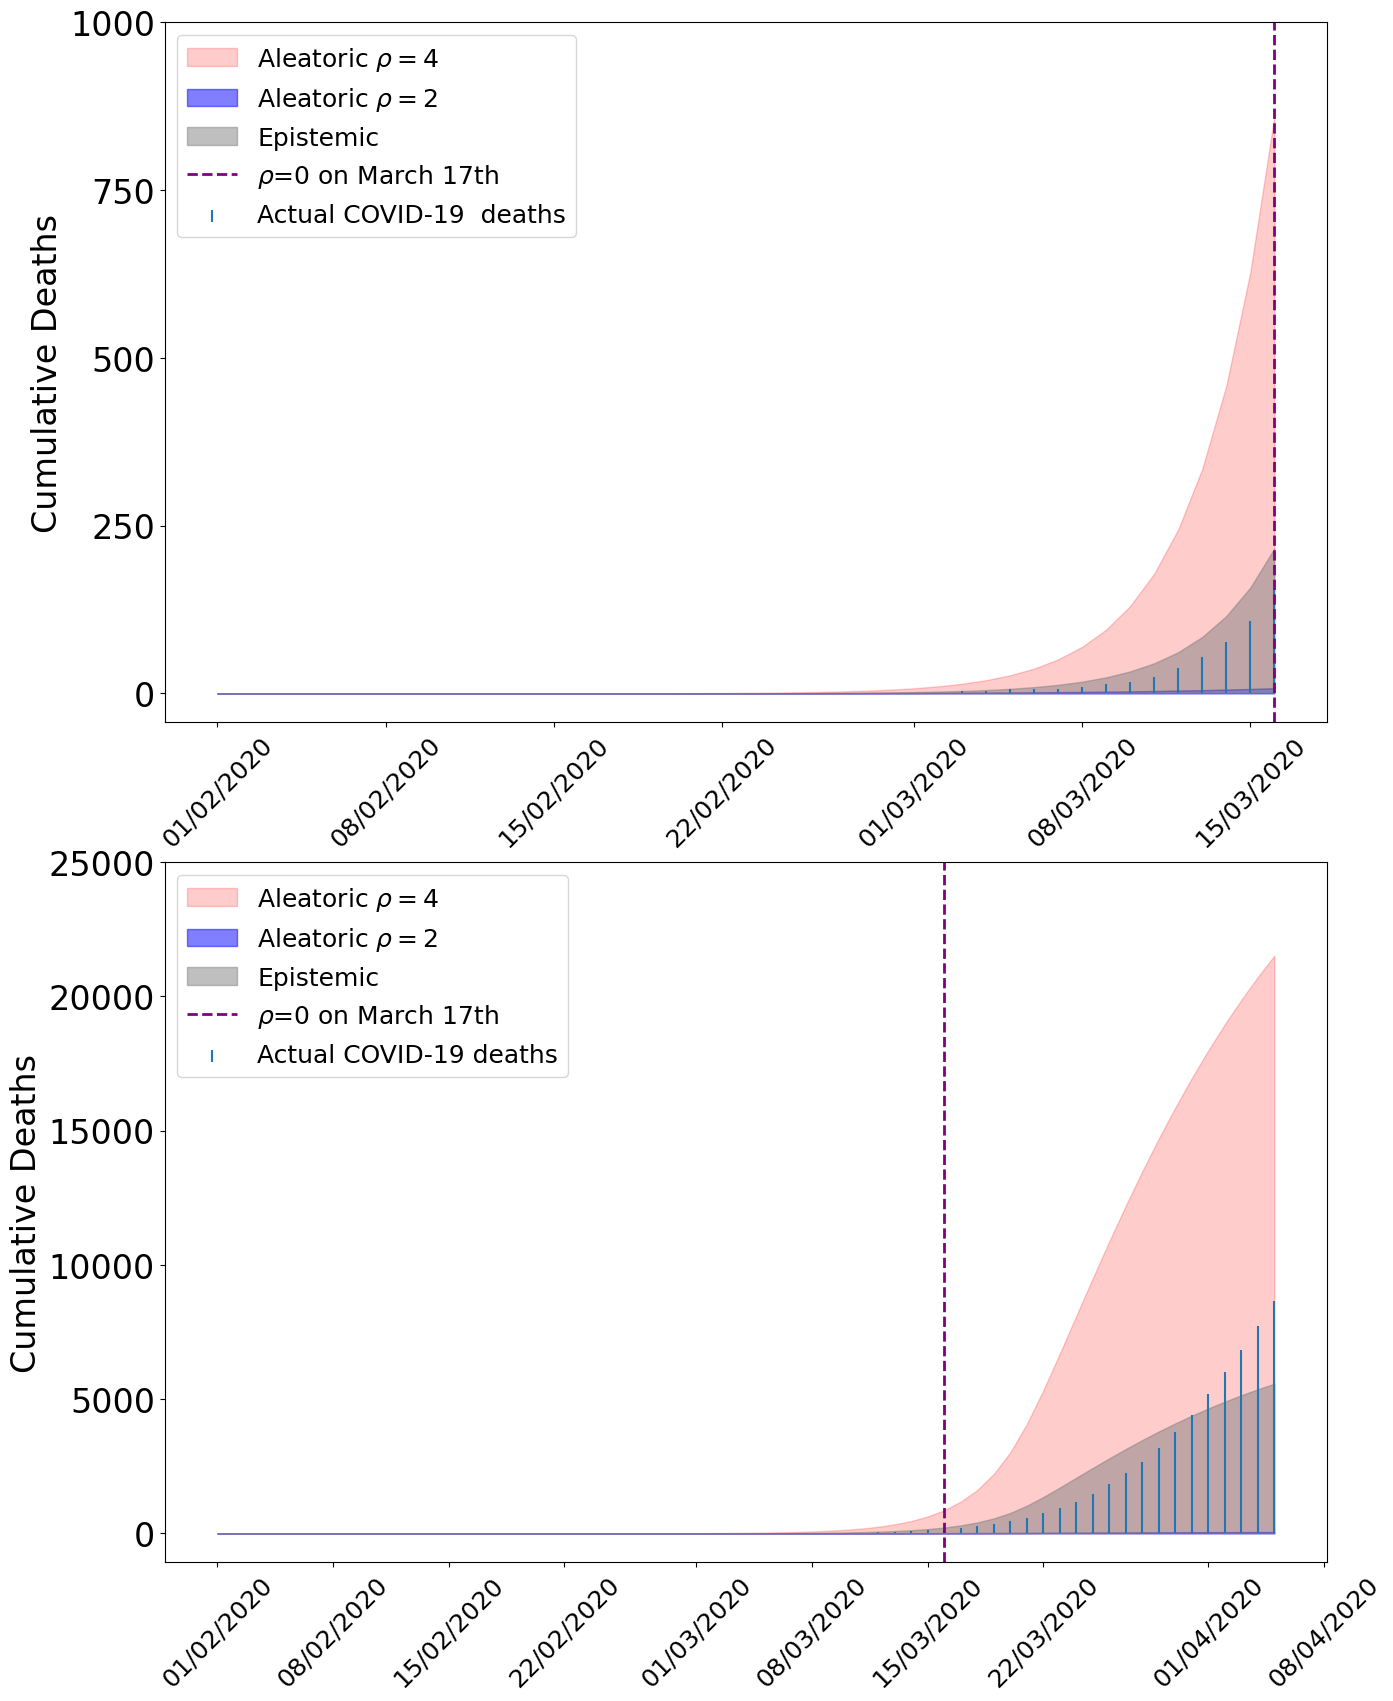

In [150]:
import matplotlib.style
import matplotlib as mpl
import matplotlib.pylab as pylab

# use latex for font rendering
#mpl.rcParams['text.usetex'] = True
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#mpl.style.use('seaborn-white')
mpl.style.use('default')
env = 'firebrick'


SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE) 

fig, ((ax1, ax2)) = plt.subplots(constrained_layout=False,nrows=2, ncols=1, figsize=(15, 20))


myFmt = mdates.DateFormatter('%d/%m/%Y')
ax1.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)

ax1.stem(dates[:sub],np.cumsum(deaths_real)[:sub],markerfmt=' ',basefmt=' ',label='Actual COVID-19  deaths')    
ax1.fill_between(dates[:sub],np.cumsum(hg[0,:])[:sub],np.cumsum(hg[1,:])[:sub],color='red',alpha=0.2,label='Aleatoric $\\rho=4$')
ax1.fill_between(dates[:sub],np.cumsum(hg[0,:])[:sub],np.cumsum(lw[1,:])[:sub],color='blue',alpha=0.5,label='Aleatoric $\\rho=2$')
ax1.fill_between(dates[:sub],np.cumsum(mn[0,:])[:sub],np.cumsum(mn[1,:])[:sub],color='gray',alpha=0.5,label='Epistemic')
ax1.axvline(x=dates[sub-1],color='purple',label="$\\rho$=0 on March 17th",linestyle='dashed',linewidth=2)
ax1.set_xlabel("")
ax1.set_ylabel("Cumulative Deaths")
ax1.set_yticks([0,250,500,750,1000])
ax1.legend(loc='upper left',fancybox=True)
plt.setp(ax1.get_xticklabels(), rotation=45)


ax2.stem(dates,np.cumsum(deaths_real),markerfmt=' ',basefmt=' ',label='Actual COVID-19 deaths')    
ax2.fill_between(dates,np.cumsum(hg[0,:]),np.cumsum(hg[1,:]),color='red',alpha=0.2,label='Aleatoric $\\rho=4$')
ax2.fill_between(dates,np.cumsum(hg[0,:]),np.cumsum(lw[1,:]),color='blue',alpha=0.5,label='Aleatoric $\\rho=2$')
ax2.fill_between(dates,np.cumsum(mn[0,:]),np.cumsum(mn[1,:]),color='gray',alpha=0.5,label='Epistemic')
ax2.axvline(x=dates[sub-1],color='purple',label="$\\rho$=0 on March 17th",linestyle='dashed',linewidth=2)
ax2.set_xlabel("")
ax2.set_ylabel("Cumulative Deaths")
ax2.set_yticks([0,5000,10000,15000, 20000, 25000])
ax2.legend(loc='upper left',fancybox=True)
plt.setp(ax2.get_xticklabels(), rotation=45)
savefigurepath = '/home/DIDE/sjbhatt/BH_notebooks/new paper/Figure2.pdf'
plt.savefig(savefigurepath,bbox_inches='tight')

In [ ]:
print(np.cumsum(hg[1,:])[-1]/np.cumsum(deaths_real)[-1])